In [216]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom

In [217]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"

# DIASources Analysis without Thresholding

## Spatial Kernel Order

In [218]:
%matplotlib inline
import Utils.DiaSourceTools as DSTools
import matplotlib.pyplot as plt
import re
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Column

filter='r'

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|('+filter+')\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    snls_lc = DSTools.build_light_curve_from_snls_file(m, c)
   
    snls_lc.add_column(Column([sn[0]]*len(snls_lc), name="id"))
    #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    
    snls_array.append(snls_lc)
    #plt.show()

In [219]:
def extract_statistics_from_datatest(ccds, parameters, directory, visit, angle = 1.):
    totals = []
    data_totals = []
    multi_matches = None
    for parameter in parameters_order:

        butler = dafPersist.Butler(directory+str(parameter)) 
        no_data_ccds = 0
        total_diaSrcs = 0
        complete_catalog = None
        for ccd in ccds:
            if butler.datasetExists("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":visit}):
                diaSrc = butler.get("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":visit})
                total_diaSrcs+=len(diaSrc)

                if multi_matches is None:
                    multi_matches = afwTable.MultiMatch(diaSrc.schema, {'parameter':int, 'ccd':int}, radius=afwGeom.Angle(angle/3600., afwGeom.degrees))
                multi_matches.add(diaSrc, {'parameter':parameter, 'ccd':ccd})

            else:
                #print ccd
                no_data_ccds +=1


        totals.append(total_diaSrcs)
        data_totals.append(36-no_data_ccds)
    
    return totals, data_totals, multi_matches

def extract_statistics_from_class_datatest(ccds, parameters, directory, visit, angle=1.):
    totals = []
    data_totals = []
    multi_matches = None
    catalogs = {}
    for parameter in parameters_order:
        catalogs[parameter] = []
        butler = dafPersist.Butler(directory+str(parameter)) 
        no_data_ccds = 0
        total_diaSrcs = 0
        complete_catalog = None
        for ccd in ccds:
            if butler.datasetExists("deepDiff_class_diaSrc", {"ccd":ccd,"filter":'r', "visit":visit}):
                diaSrc = butler.get("deepDiff_class_diaSrc", {"ccd":ccd,"filter":'r', "visit":visit})
                total_diaSrcs+=len(diaSrc)
                catalogs[parameter].append(diaSrc)
                if multi_matches is None:
                    multi_matches = afwTable.MultiMatch(diaSrc.schema, {'parameter':int, 'ccd':int}, radius=afwGeom.Angle(angle/3600., afwGeom.degrees))
                multi_matches.add(diaSrc, {'parameter':parameter, 'ccd':ccd})

            else:
                #print ccd
                no_data_ccds +=1


        totals.append(total_diaSrcs)
        data_totals.append(36-no_data_ccds)
    
    return totals, data_totals, multi_matches, catalogs

def get_stamps(obj, directory, visit):
    stamp_list = []
    for detection in obj:
        CenterRa = detection['coord_ra']
        CenterDec = detection['coord_dec']
        butler = dafPersist.Butler(directory+str(detection['parameter'])) 
        diffExp = butler.get("deepDiff_differenceExp", dataId={"filter":'r','visit': visit, 'ccd':detection['ccd']})
        box = diffExp.getBBox()
        wcs = diffExp.getWcs()
        coord = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        Center = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        Begin = afwGeom.Point2I(Center.getX() - 16, Center.getY() - 16)
        End = afwGeom.Point2I(Center.getX() + 15, Center.getY() + 15)

        newBox = afwGeom.Box2I(Begin,End) 

        try:

            stamp = diffExp.Factory(diffExp,newBox, True)            
            stamp_list.append(stamp)

        except Exception, e:
            stamp_list.append(None)
            print e
            pass
        
    return stamp_list

def extract_coincidences(results):
    matches = {}
    for result in results:

        if matches.has_key(result.get("object"))==False:
            matches[result.get("object")] = []
        matches[result.get("object")].append(result)
    return matches

def display_sources(stamp_list):
    fig = plt.figure(figsize=(5,5*len(stamp_list)))
    for i, stamp in enumerate(stamp_list):
        
        if stamp is not None:

            fig.add_subplot(len(stamp_list), 1, i+1)
            plt.subplot(len(stamp_list), 1, i+1)
            img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
            img_arr = np.nan_to_num(img_arr)
            w,h = stamp.getWidth(), stamp.getHeight()  
            plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
    plt.show()


In [371]:
ccds = range(0,36)
parameters_order = range(0,9)
directory = DATADIR+"/deepDiffTests/SpatialKernelOrders/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches = extract_statistics_from_datatest(ccds, parameters_order, directory, visit)

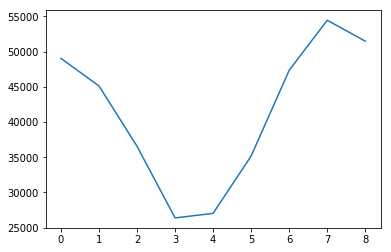

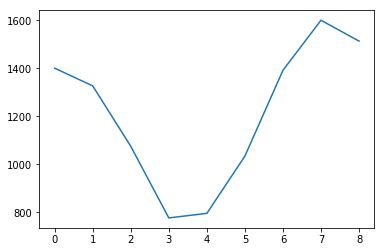

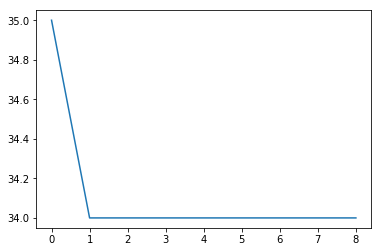

In [372]:
%matplotlib inline
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [373]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)

In [374]:
objs = []
for match in matches:
    if len(matches[match]) == 9:
        obj = matches[match]
        objs.append(obj)

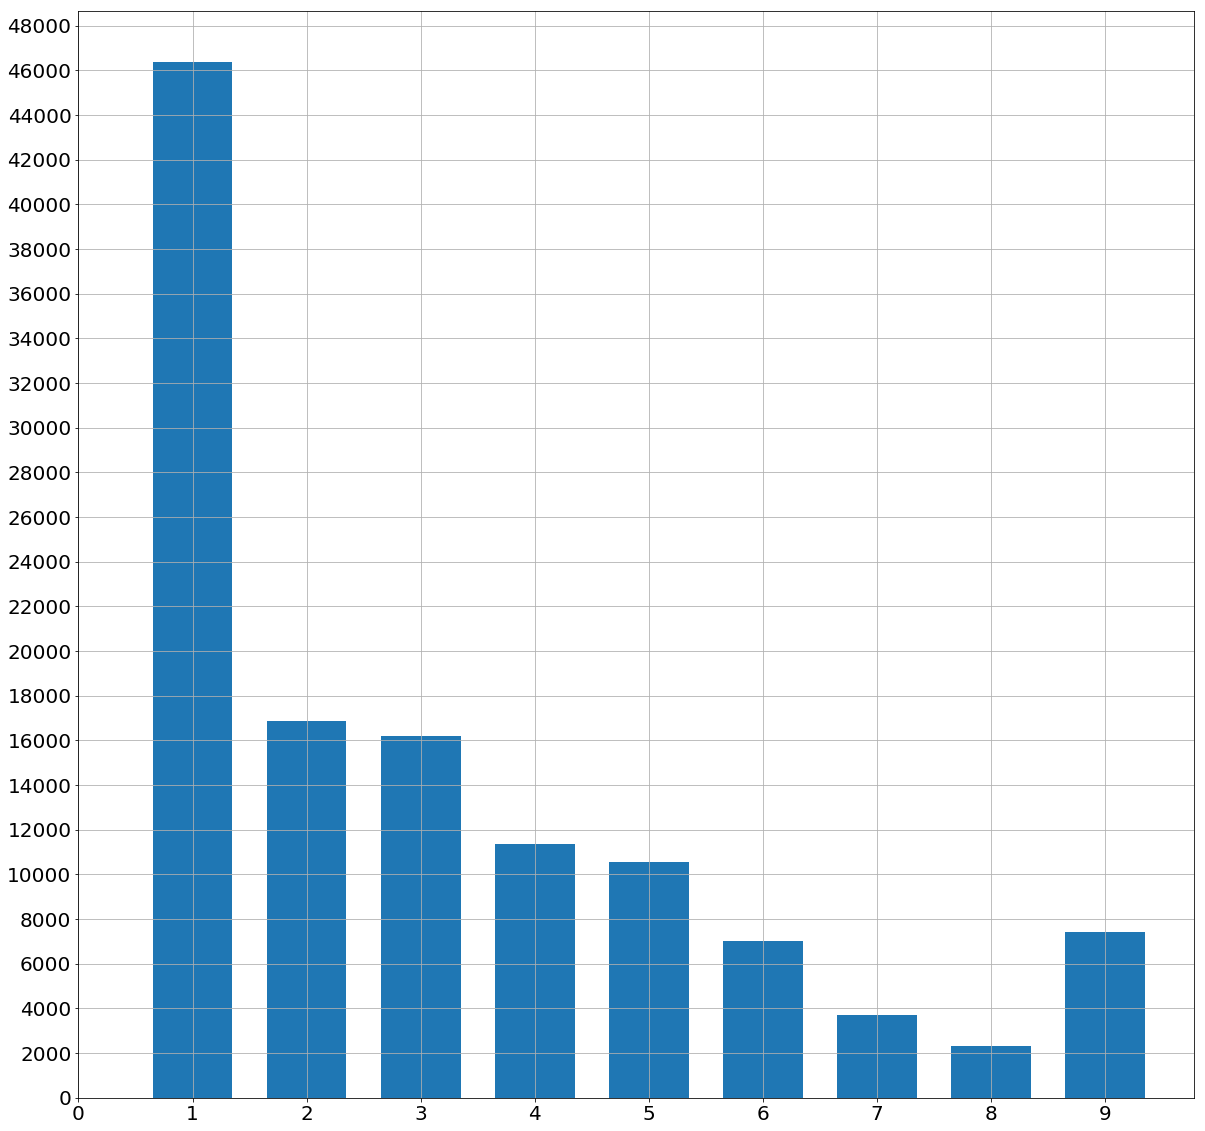

In [375]:
lenghts = []
for match in matches:
    lenghts.append(len(matches[match]))

plt.figure(figsize=(20, 20))

hist, bins = np.histogram(lenghts, bins  =np.arange(0.5, len(parameters_order)+1))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xticks(np.arange(0, max(lenghts)+1, 1) , size=20 )
plt.yticks(np.arange(0,max(hist)+2000,2000) , size=20 )
plt.grid(True)
plt.show()

In [ ]:

obj = objs[5000]
stamp_list = get_stamps(obj, directory, visit)

In [ ]:
len(stamp_list)

In [ ]:
display_sources(stamp_list)

## Cell Size in pixels

In [376]:
ccds = range(0,36)
parameters_order = range(50,525, 25)
directory = DATADIR+"deepDiffTests/CellSizes/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches = extract_statistics_from_datatest(ccds, parameters_order, directory, visit)

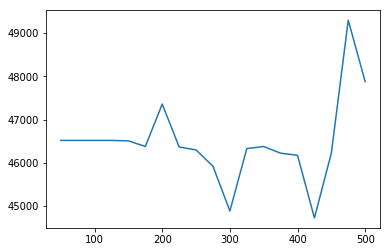

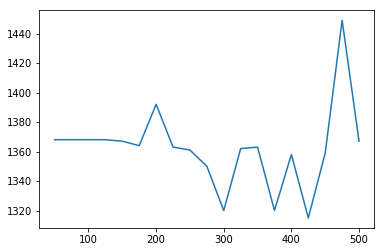

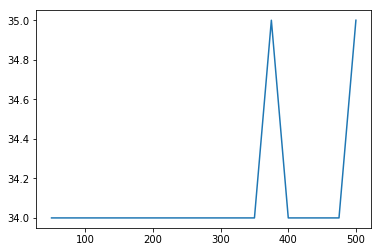

In [377]:
%matplotlib inline
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [378]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)

In [379]:
objs = []
for match in matches:
    if len(matches[match]) > 10:
        obj = matches[match]
        objs.append(obj)

In [380]:
len(objs)

47661

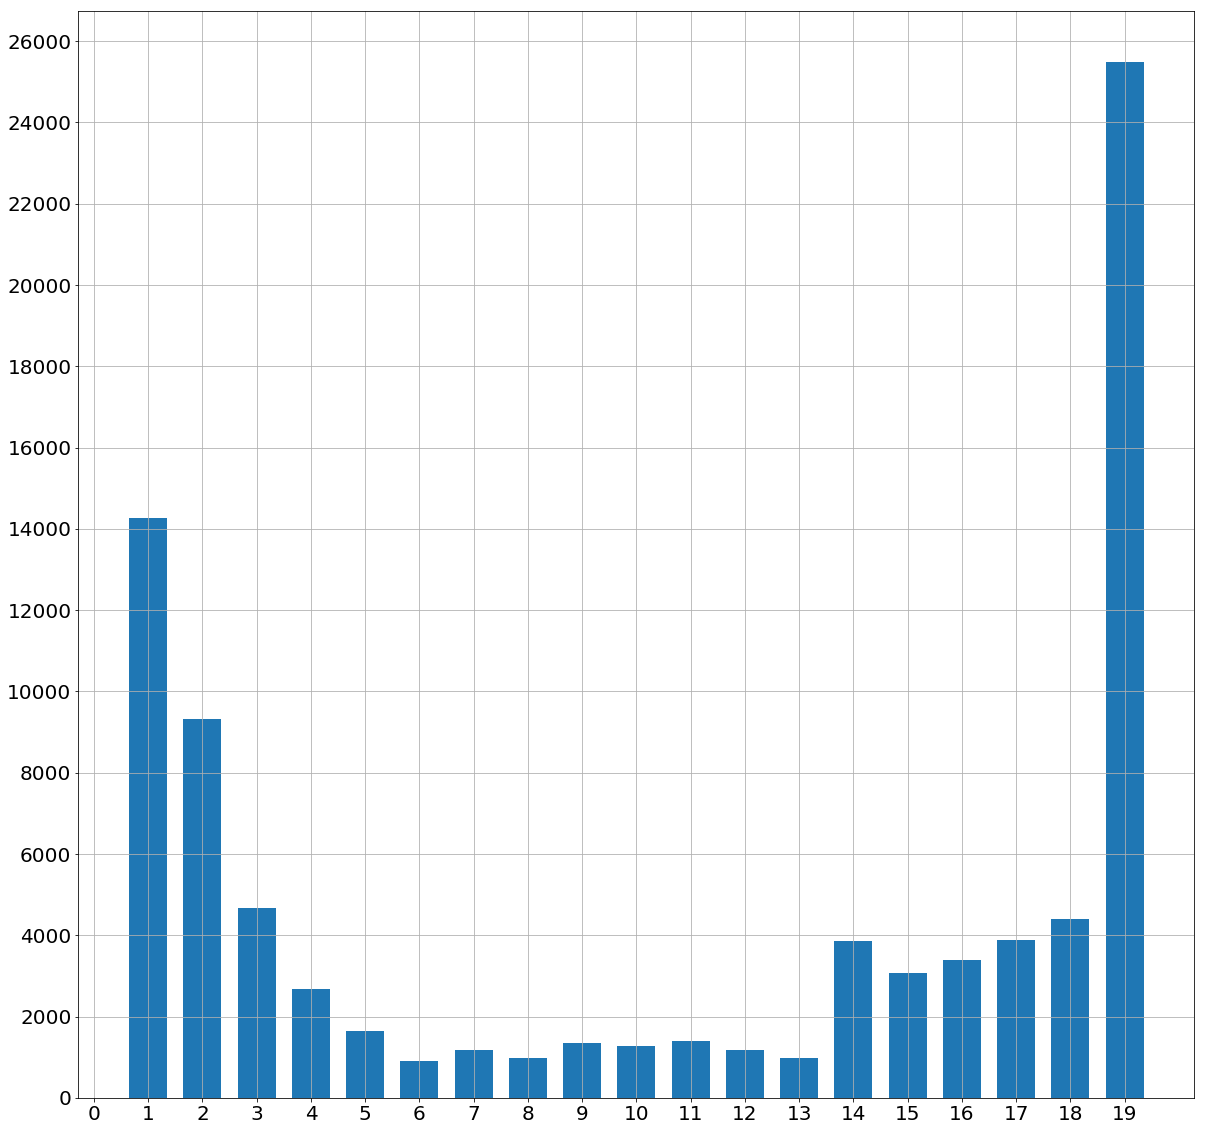

In [381]:
lenghts = []
for match in matches:
    lenghts.append(len(matches[match]))

plt.figure(figsize=(20, 20))

hist, bins = np.histogram(lenghts, bins  =np.arange(0.5, len(parameters_order)+1))

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xticks(np.arange(0, max(lenghts)+1, 1) , size=20 )
plt.yticks(np.arange(0,max(hist)+2000,2000) , size=20 )
plt.grid(True)
plt.show()

In [ ]:

obj = objs[5000]
stamp_list = get_stamps(obj, directory, visit)

In [ ]:
display_sources(stamp_list)

## Max. N and Deg Gaussian

In [382]:
ccds = range(0,36)
parameters_order = range(3,9, 1)
directory = DATADIR+"deepDiffTests/DegGaussians/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches = extract_statistics_from_datatest(ccds, parameters_order, directory, visit)

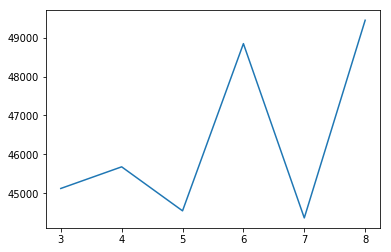

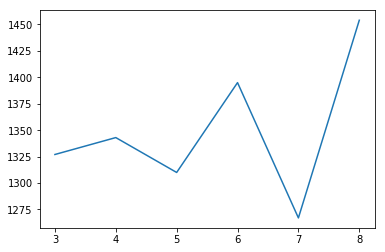

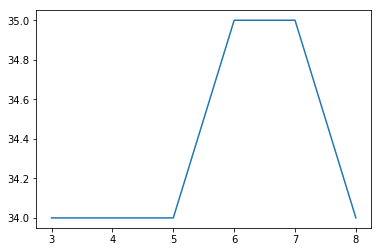

In [383]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [384]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)

In [385]:
objs = []
for match in matches:
    if len(matches[match]) > 0:
        obj = matches[match]
        objs.append(obj)

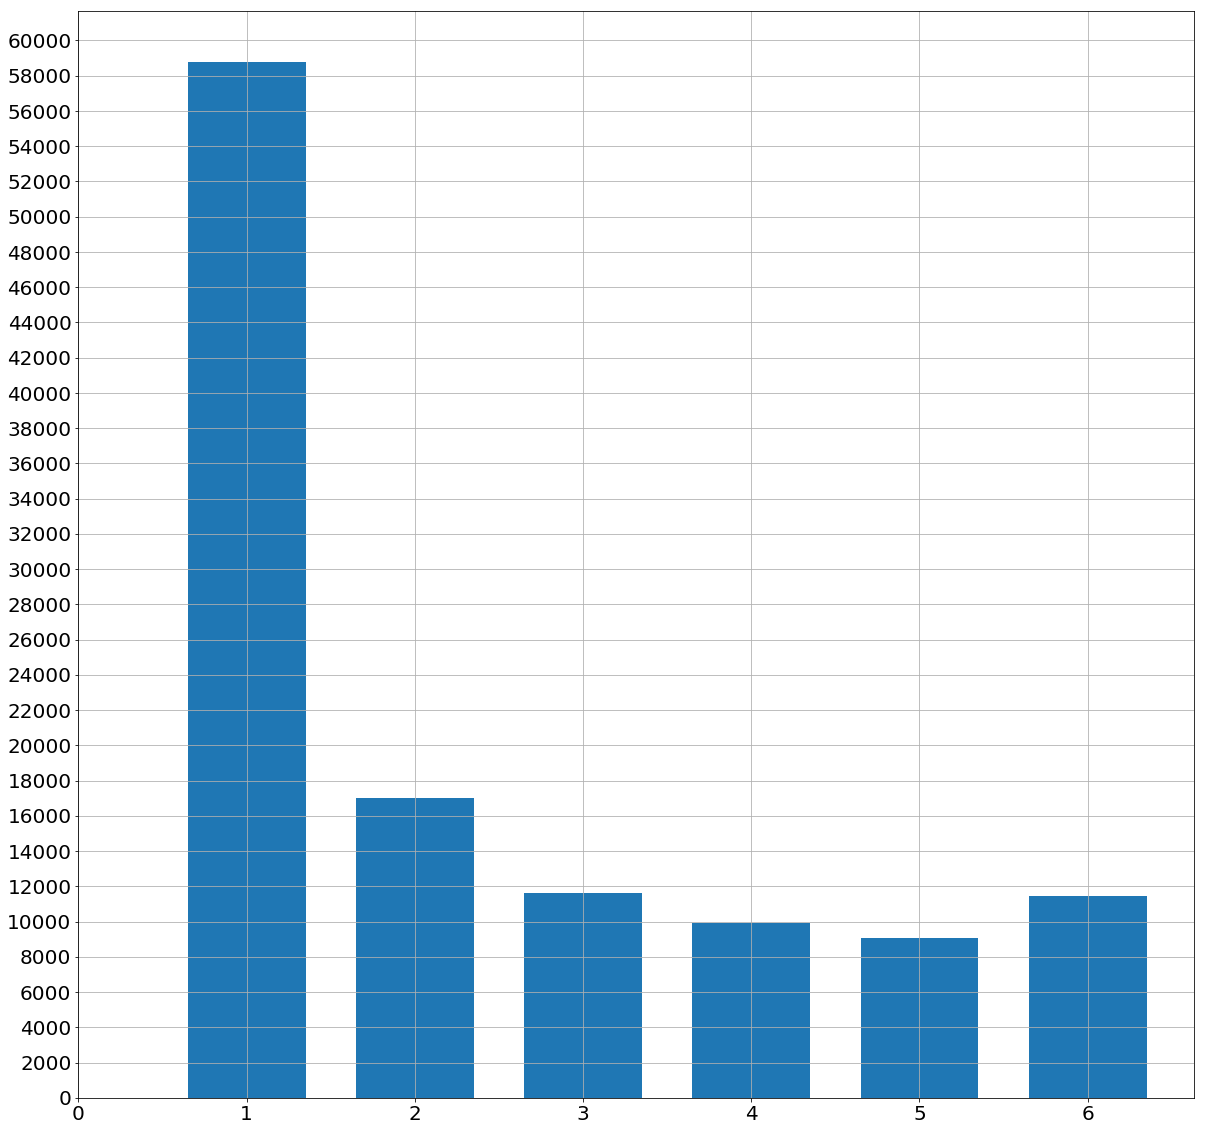

In [386]:
lenghts = []
for match in matches:
    lenghts.append(len(matches[match]))

plt.figure(figsize=(20, 20))

hist, bins = np.histogram(lenghts, bins  =np.arange(0.5, len(parameters_order)+1))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xticks(np.arange(0, max(lenghts)+1, 1) , size=20 )
plt.yticks(np.arange(0,max(hist)+2000,2000) , size=20 )
plt.grid(True)
plt.show()

SN 06D3em


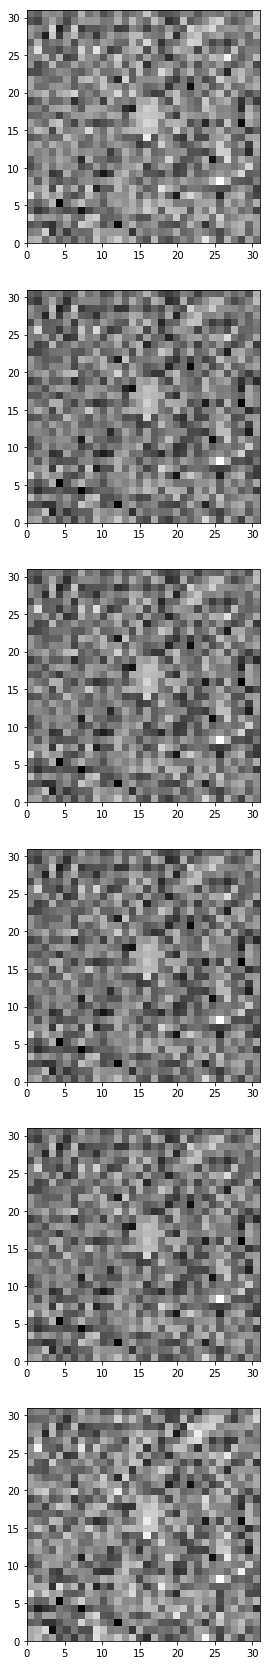

SN 06D3cn


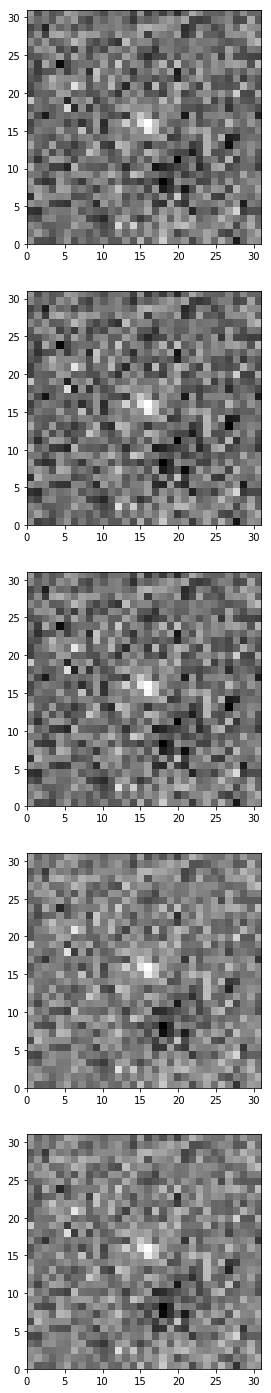

SN 06D3dt


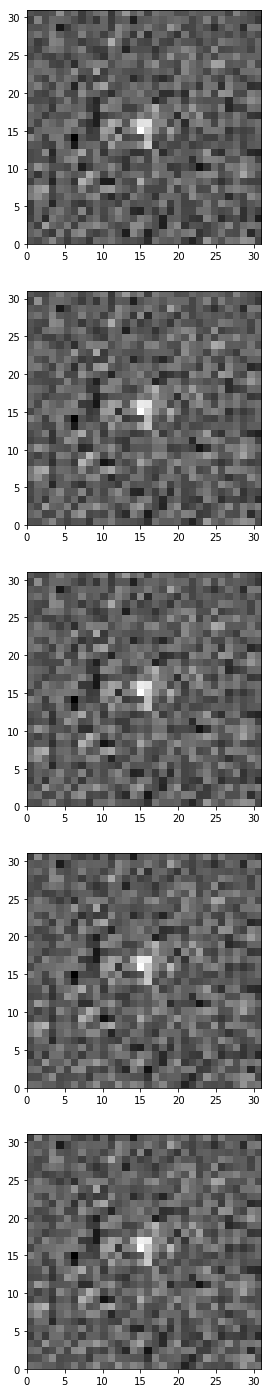

SN 06D3el


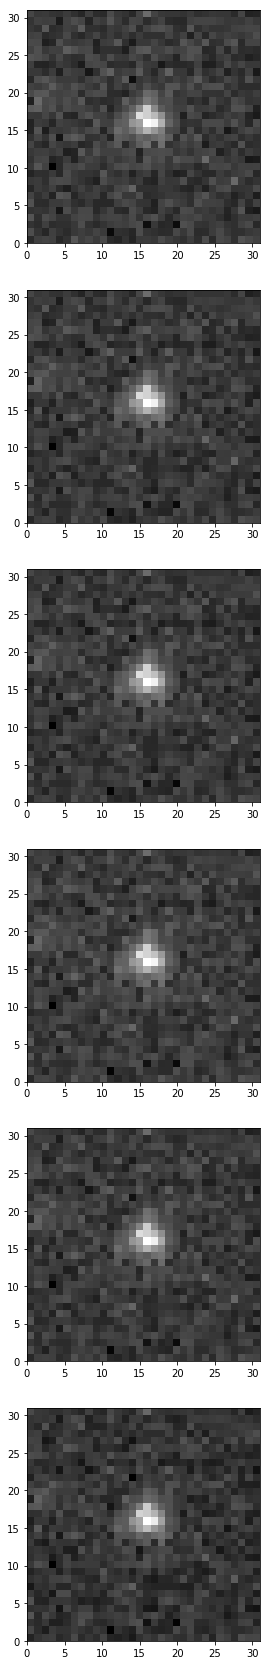

SN 06D3ed


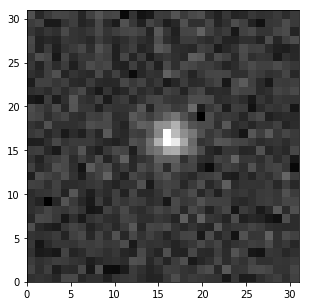

In [264]:
ans = []
for obj in objs:
    for sn in snls_array:
        coord_obj = {"ra": obj[0]["coord_ra"], "dec": obj[0]["coord_dec"]}
        if DSTools.source_distance(sn[0], coord_obj) < 0.5:
            ans.append((sn["id"][0],obj))
            break
            
for id, obj in ans:
    print "SN", id
    stamp_list = get_stamps(obj, directory, visit)
    display_sources(stamp_list)

In [ ]:
display_sources(stamp_list)

# Classified sources after thresholding

## Spatial Kernel Order

In [310]:
ccds = range(0,36)
parameters_order = range(0,9)
directory = DATADIR+"/deepDiffTests/SpatialKernelOrders/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches, catalogs = extract_statistics_from_class_datatest(ccds, parameters_order, directory, visit)

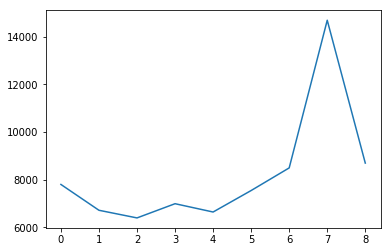

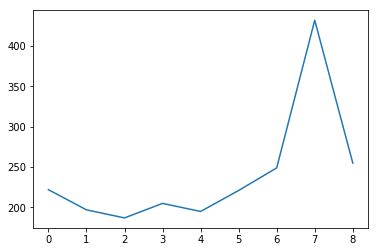

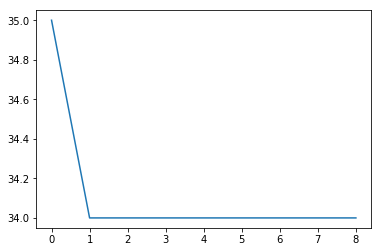

In [311]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [312]:
def initialize_data(target_dict):
    input_dict = {}
    for key in target_dict:
        input_dict[target_dict[key]] = 0
    return input_dict

In [313]:

classification_dict = {0:"Dipole type I", 1: "Dipole type II", 3:"Fringe", 4: "Artifact", 5:"Negative", 6:"Positive", 7:"Point Positive"}
all_data = {}



for key in catalogs:
    data = initialize_data(classification_dict)
    visit_catalogs = catalogs[key]
    for catalog in visit_catalogs:
        for source in catalog:
            data[classification_dict[source["classification_dipole"]]] += 1
    all_data[key] = data

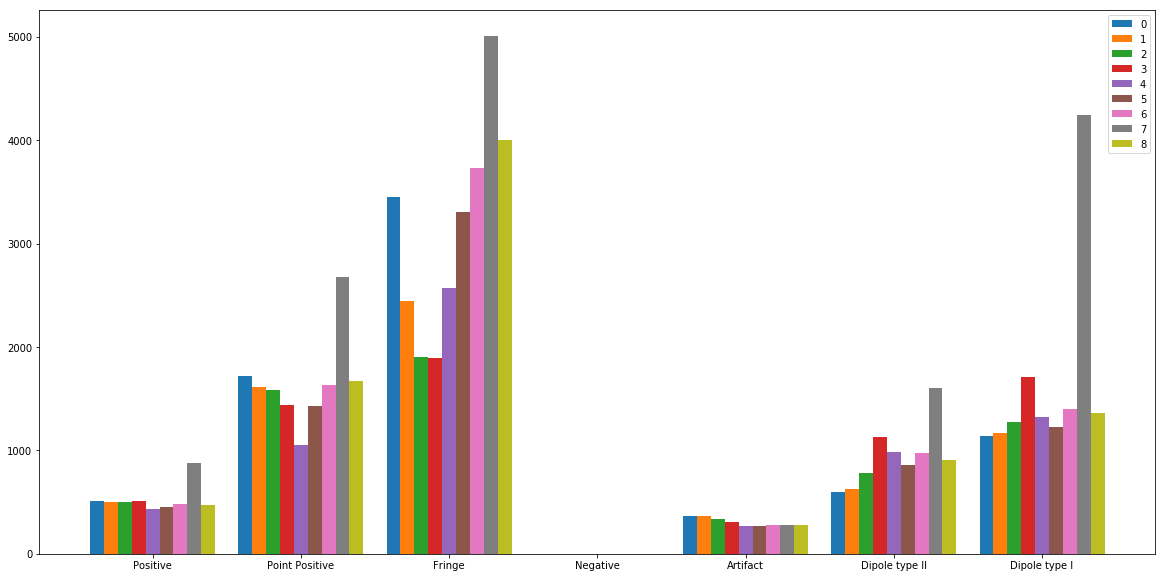

In [314]:
plt.figure(figsize=(20,10))

size = 0.75
mi_size = size/2
x = np.arange(len(classification_dict.keys()))
len_pars = len(all_data)
bar_lenght = size/(len_pars-1)



for i, key in enumerate(np.sort(all_data.keys())):
    p = plt.bar( x+(i*bar_lenght-mi_size) , all_data[key].values(), bar_lenght, label=key)

plt.xticks(x, all_data[key].keys())
plt.legend()
plt.show()

In [315]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)



In [323]:
objs = []
for match in matches:
    if len(matches[match]) == 9:
        obj = matches[match]
        objs.append(obj)
        
len(objs)

1484

In [324]:
count = 0
for l in lenghts:
    if l == 9:
        count+=1
print count

1484


In [342]:
np.add(parameters_order,1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [355]:

np.histogram(lenghts, bins = np.arange(0.5, len(parameters_order)+1))

(array([13983,  2008,  1613,  1659,  1657,  1430,  1008,   992,  1484]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]))

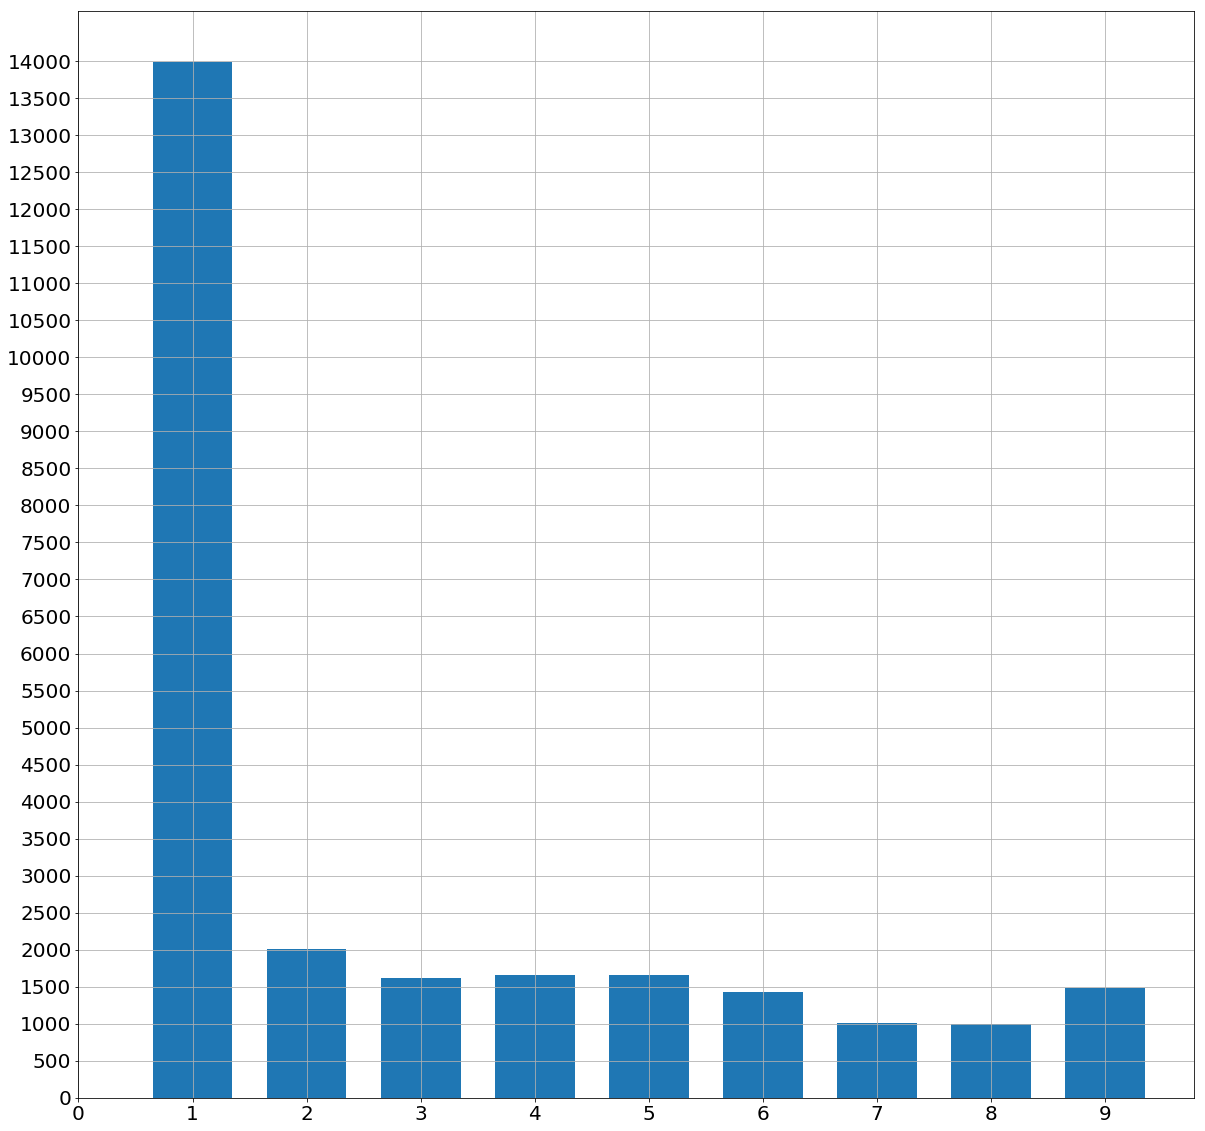

In [351]:
lenghts = []
for match in matches:
    lenghts.append(len(matches[match]))

plt.figure(figsize=(20, 20))

hist, bins = np.histogram(lenghts, bins =  np.add(parameters_order+[9], 0.5))
#hist, bins = np.histogram(lenghts, bins = 9)


width = 0.7*(bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xticks(np.arange(0, max(lenghts)+1, 1) , size=20 )
plt.yticks(np.arange(0,max(hist)+500,500) , size=20 )
plt.grid(True)
plt.show()

In [298]:
#obj = objs[100]
#stamp_list = get_stamps(obj, directory, visit)
#display_sources(stamp_list)

SN 06D3ed


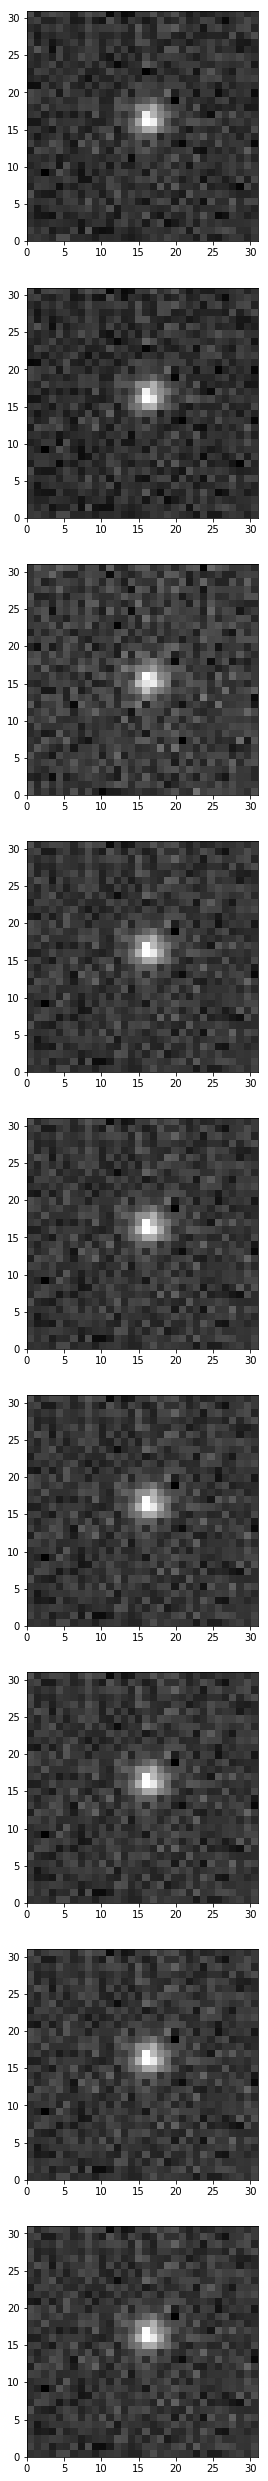

SN 06D3el


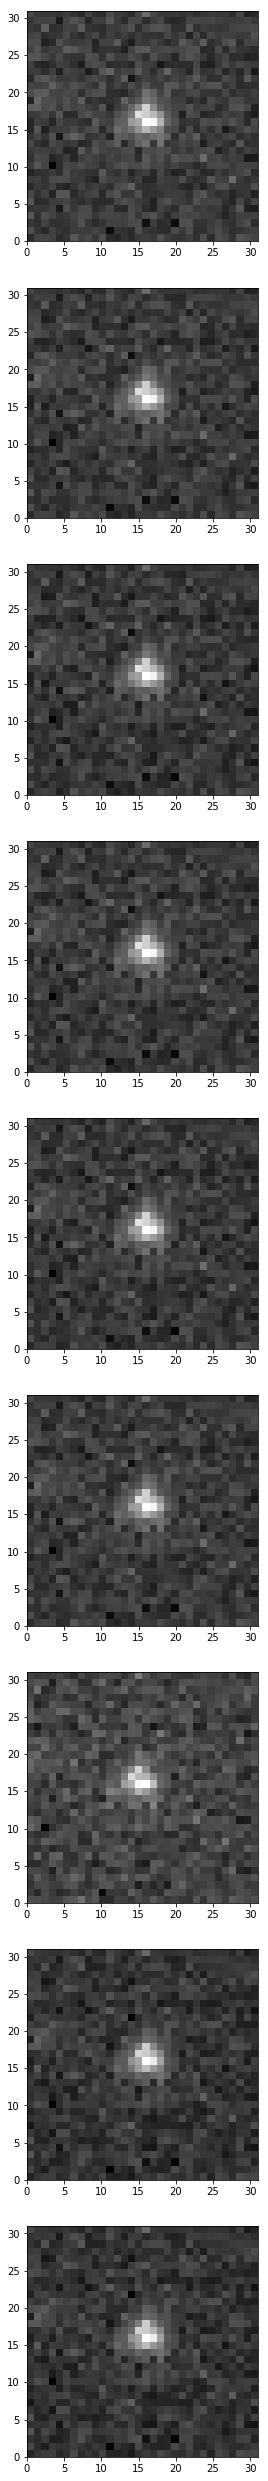

SN 06D3dt


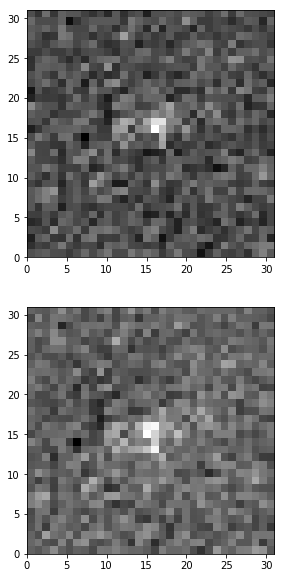

In [299]:
for match in matches:
        obj = matches[match]
        objs.append(obj)
        
len(objs)

ans = []
for obj in objs:
    for sn in snls_array:
        coord_obj = {"ra": obj[0]["coord_ra"], "dec": obj[0]["coord_dec"]}
        if DSTools.source_distance(sn[0], coord_obj) < 0.5:
            ans.append((sn["id"][0],obj))
            break
            
for id, obj in ans:
    print "SN", id
    stamp_list = get_stamps(obj, directory, visit)
    display_sources(stamp_list)

## Cell Size in Pixels

In [356]:
ccds = range(0,36)
parameters_order = range(50,525, 25)
directory = DATADIR+"/deepDiffTests/CellSizes/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches, catalogs = extract_statistics_from_class_datatest(ccds, parameters_order, directory, visit)

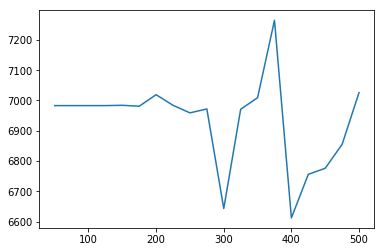

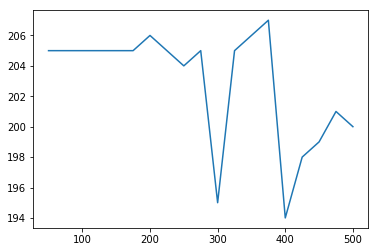

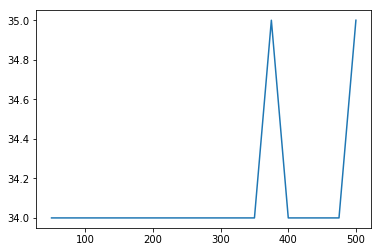

In [357]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [358]:

classification_dict = {0:"Dipole type I", 1: "Dipole type II", 3:"Fringe", 4: "Artifact", 5:"Negative", 6:"Positive", 7:"Point Positive"}
all_data = {}





for key in catalogs:
    data = initialize_data(classification_dict)
    visit_catalogs = catalogs[key]
    for catalog in visit_catalogs:
        for source in catalog:
            data[classification_dict[source["classification_dipole"]]] += 1
    all_data[key] = data

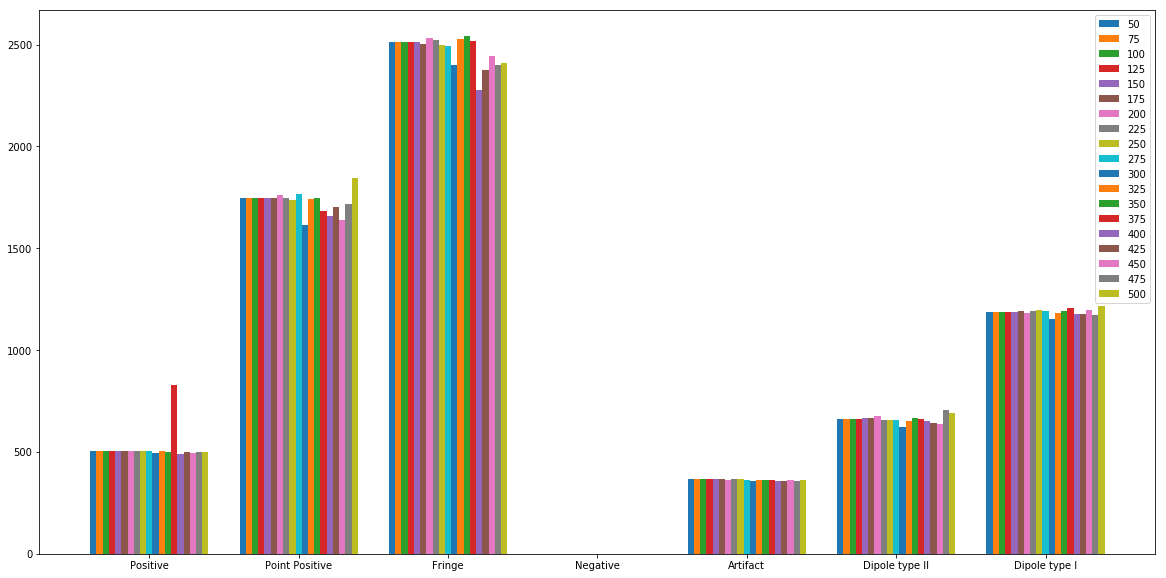

In [359]:
plt.figure(figsize=(20,10))

size = 0.75
mi_size = size/2
x = np.arange(len(classification_dict.keys()))
len_pars = len(all_data)
bar_lenght = size/(len_pars-1)



for i, key in enumerate(np.sort(all_data.keys())):
    p = plt.bar( x+(i*bar_lenght-mi_size) , all_data[key].values(), bar_lenght, label=key)

plt.xticks(x, all_data[key].keys())
plt.legend()
plt.show()

In [360]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)
objs = []


In [361]:
for match in matches:
    if len(matches[match]) > 10:
        obj = matches[match]
        objs.append(obj)
        
len(objs)

6893

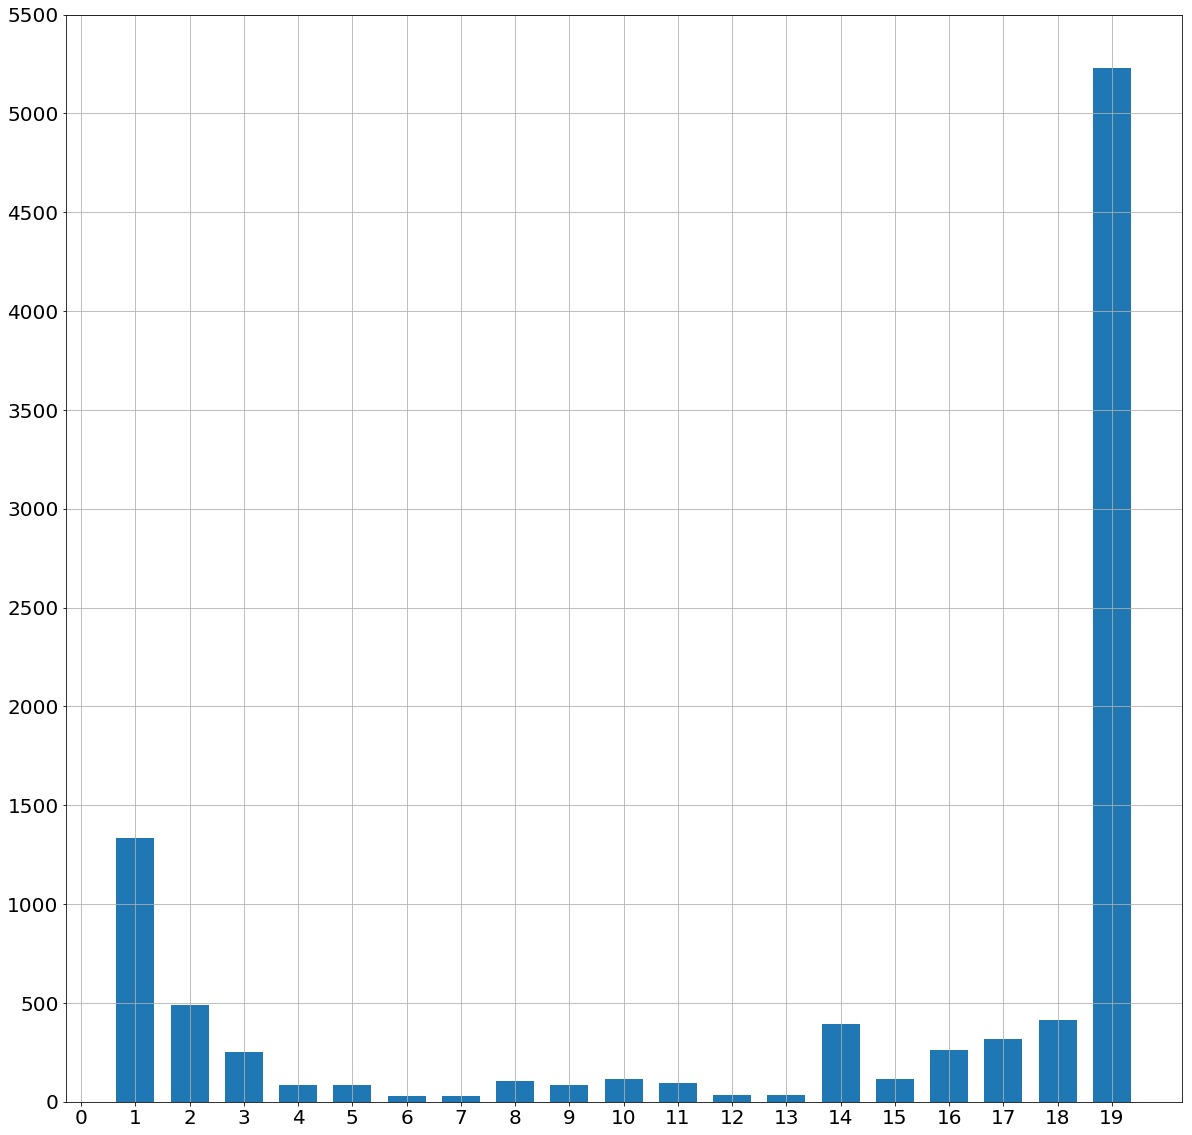

In [362]:
lenghts = []
for match in matches:
    lenghts.append(len(matches[match]))

plt.figure(figsize=(20, 20))

hist, bins = np.histogram(lenghts, bins  =np.arange(0.5, len(parameters_order)+1))

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xticks(np.arange(0, max(lenghts)+1, 1) , size=20 )
plt.yticks(np.arange(0,max(hist)+500,500) , size=20 )
plt.grid(True)
plt.show()

In [282]:
#obj = objs[6000]
#stamp_list = get_stamps(obj, directory, visit)
#display_sources(stamp_list)

SN 06D3ed


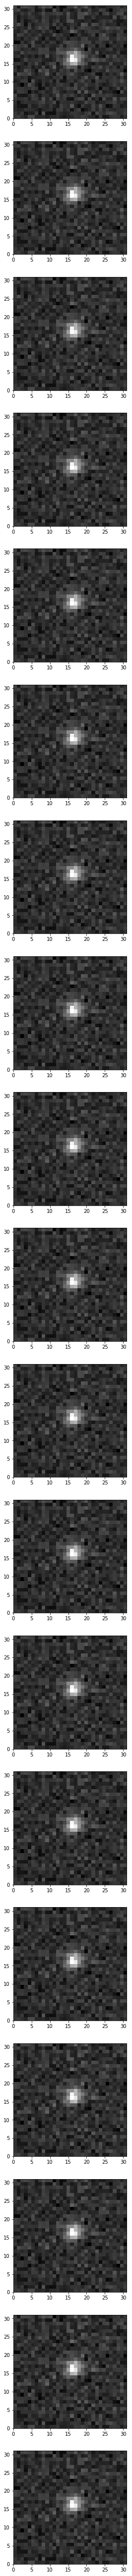

SN 06D3el


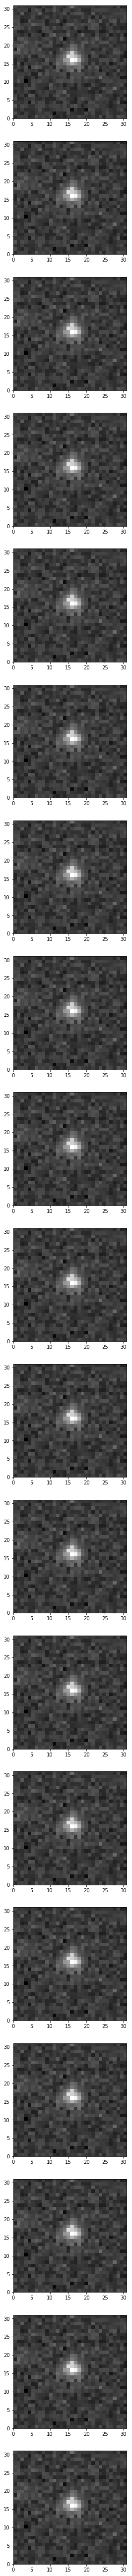

SN 06D3ed


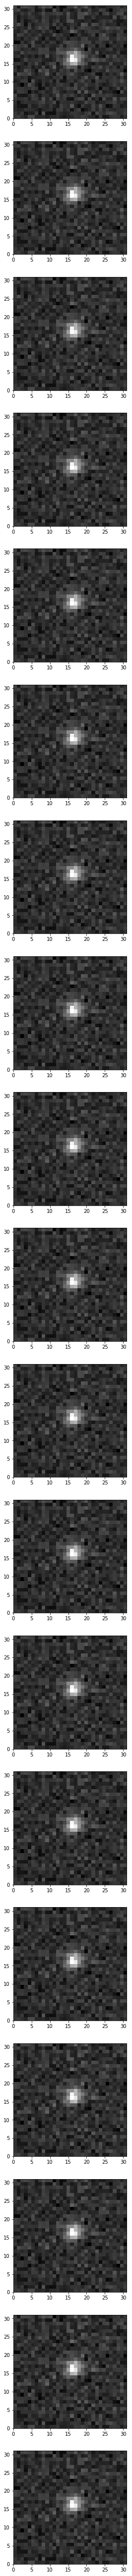

SN 06D3el


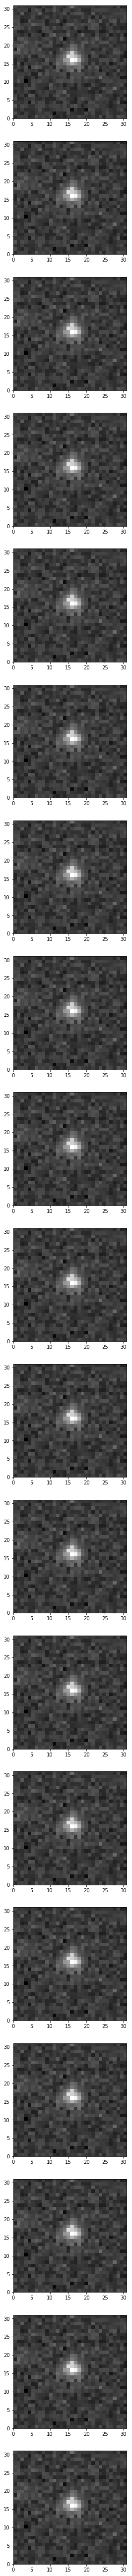

SN 06D3fp


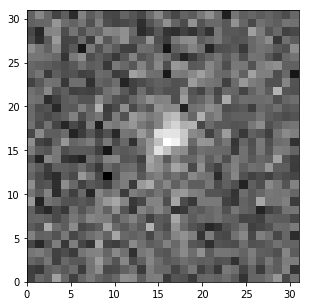

In [283]:
for match in matches:
        obj = matches[match]
        objs.append(obj)
        
len(objs)

ans = []
for obj in objs:
    for sn in snls_array:
        coord_obj = {"ra": obj[0]["coord_ra"], "dec": obj[0]["coord_dec"]}
        if DSTools.source_distance(sn[0], coord_obj) < 0.5:
            ans.append((sn["id"][0],obj))
            break
            
for id, obj in ans:
    print "SN", id
    stamp_list = get_stamps(obj, directory, visit)
    display_sources(stamp_list)

## Max N. and Degree of Gaussians

In [363]:
ccds = range(0,36)
parameters_order = range(3,9, 1)
directory = DATADIR+"deepDiffTests/DegGaussians/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches, catalogs = extract_statistics_from_class_datatest(ccds, parameters_order, directory, visit, angle=0.2)

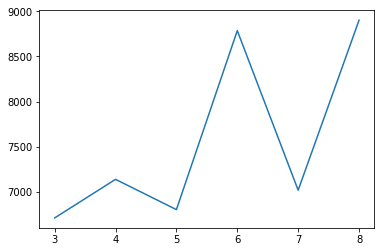

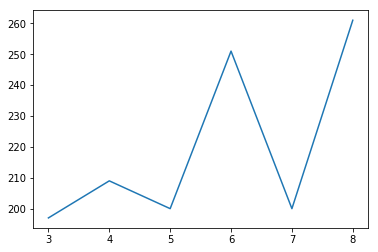

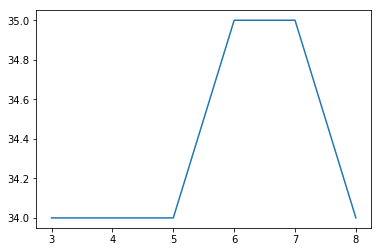

In [364]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [365]:
visit_catalogs = catalogs[3]
classification_dict = {0:"Dipole type I", 1: "Dipole type II", 3:"Fringe", 4: "Artifact", 5:"Negative", 6:"Positive", 7:"Point Positive"}
all_data = {}



for key in catalogs:
    data = initialize_data(classification_dict)
    visit_catalogs = catalogs[key]
    for catalog in visit_catalogs:
        for source in catalog:
            data[classification_dict[source["classification_dipole"]]] += 1
    all_data[key] = data

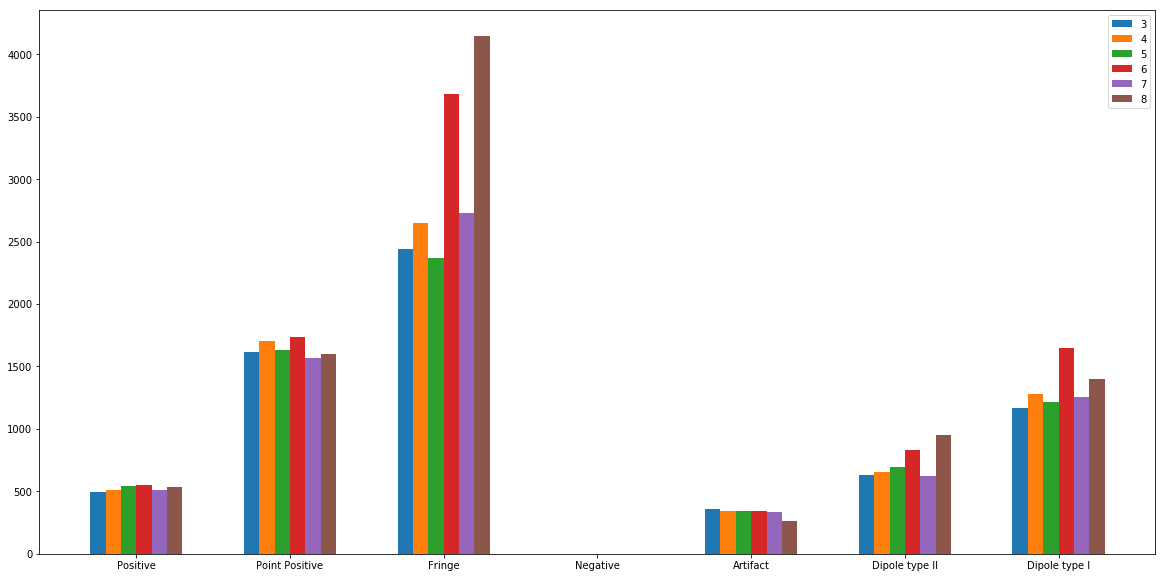

In [366]:
plt.figure(figsize=(20,10))

x = np.arange(len(classification_dict.keys()))
len_pars = len(all_data)
bar_lenght = 0.5/(len_pars-1)

for i, key in enumerate(all_data):
    
    p = plt.bar( x+(i*bar_lenght-0.25) , all_data[key].values(), bar_lenght, label=key)

plt.xticks(x, all_data[key].keys())
plt.legend()
plt.show()

In [367]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)
objs = []


In [368]:
for match in matches:
    if len(matches[match]) == 6:
        obj = matches[match]
        objs.append(obj)
        
len(objs)

2374

In [369]:
lenghts = []
for match in matches:
    lenghts.append(len(matches[match]))

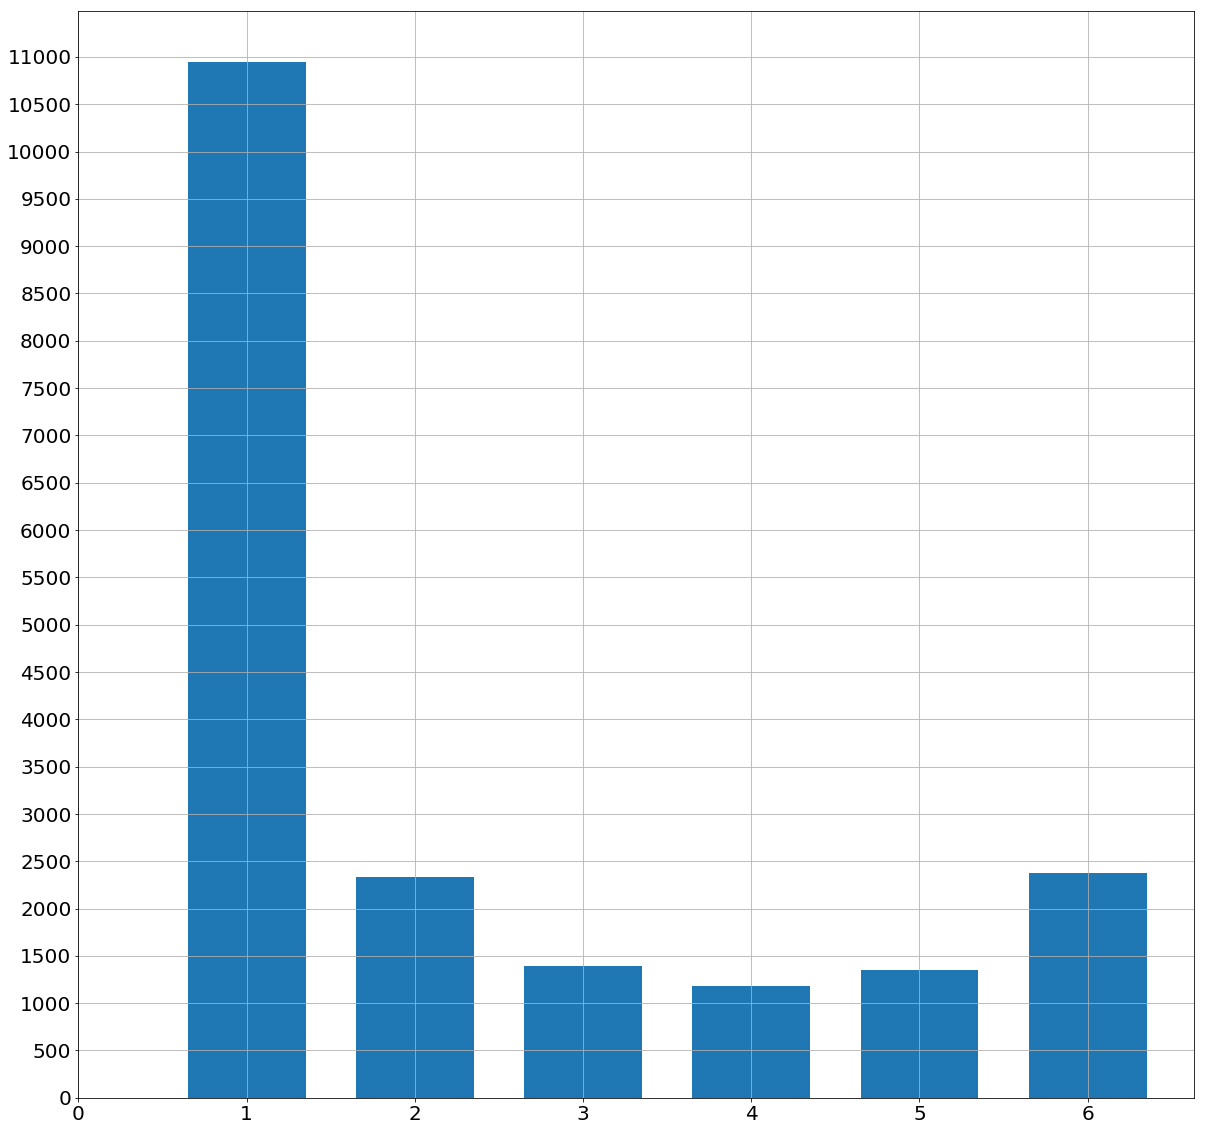

In [370]:
plt.figure(figsize=(20, 20))

hist, bins = np.histogram(lenghts, bins  =np.arange(0.5, len(parameters_order)+1))


width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xticks(np.arange(0, max(lenghts)+1, 1) , size=20 )
plt.yticks(np.arange(0,max(hist)+500,500) , size=20 )
plt.grid(True)
plt.show()

SN 06D3ed


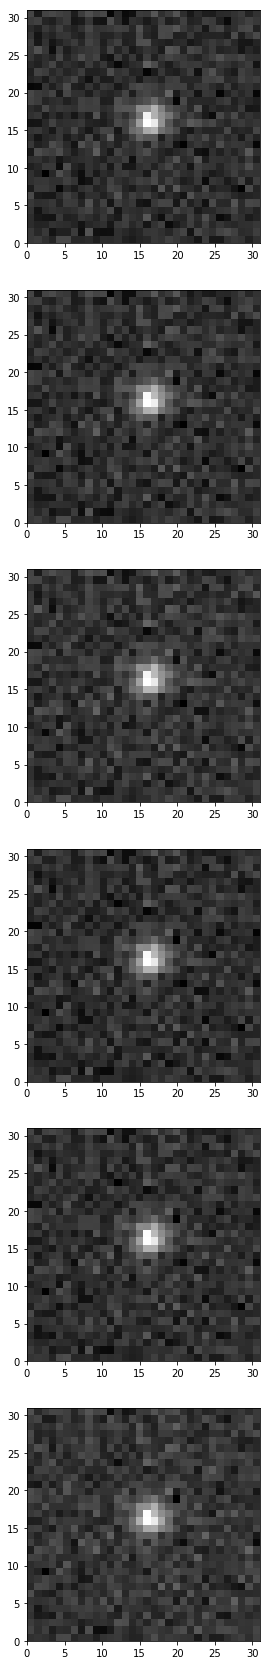

SN 06D3el


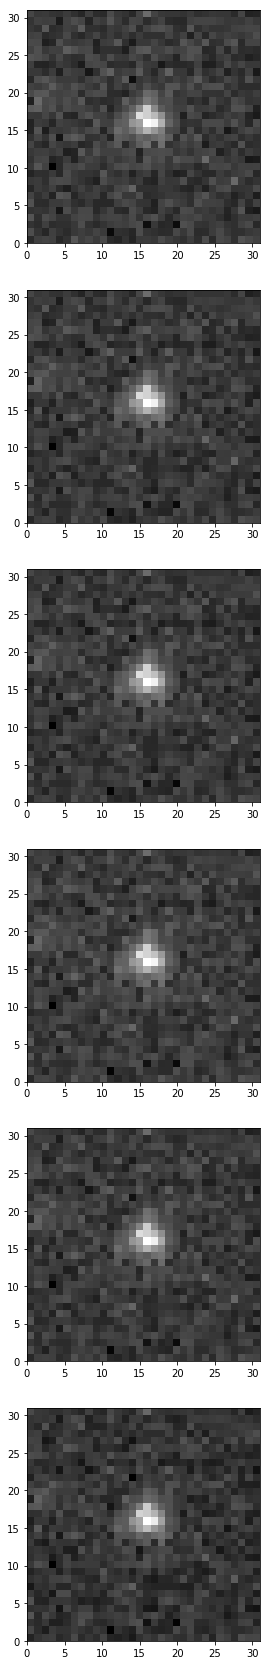

SN 06D3ed


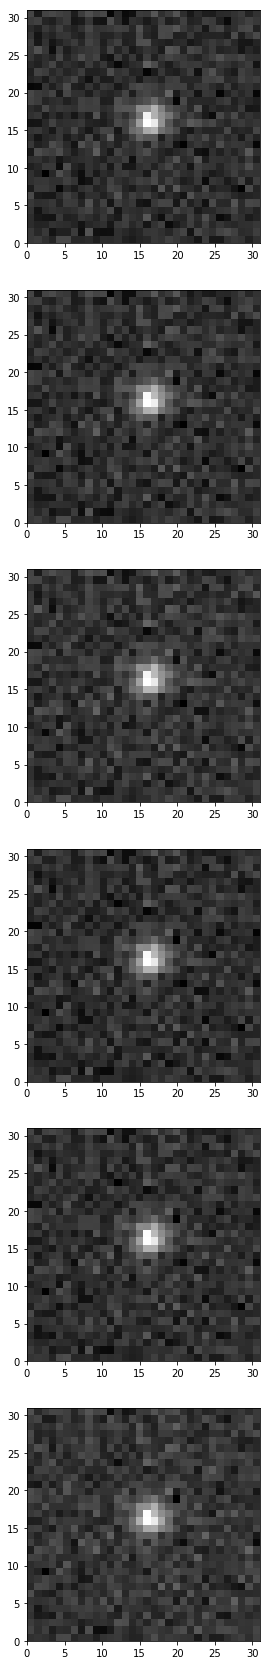

SN 06D3el


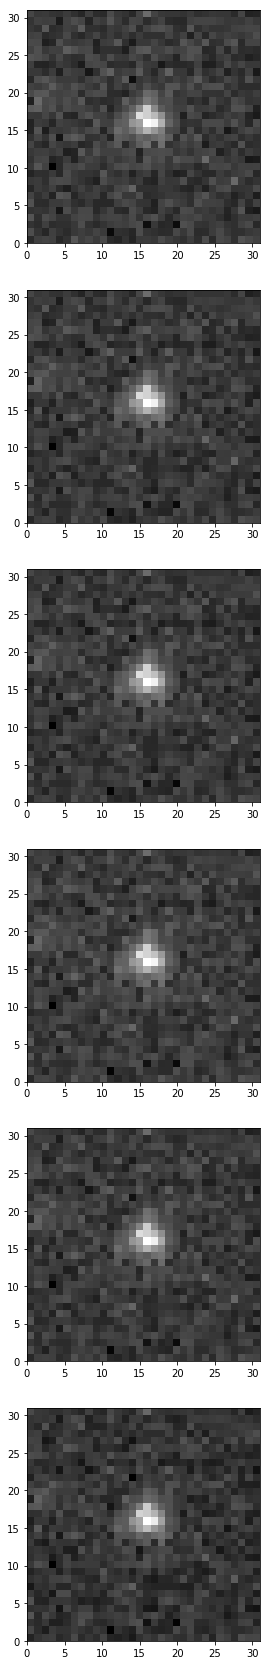

SN 06D3cn


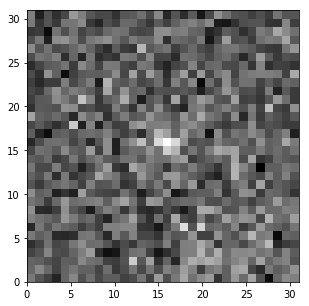

In [273]:
for match in matches:
        obj = matches[match]
        objs.append(obj)
        
len(objs)

ans = []
for obj in objs:
    for sn in snls_array:
        coord_obj = {"ra": obj[0]["coord_ra"], "dec": obj[0]["coord_dec"]}
        if DSTools.source_distance(sn[0], coord_obj) < 0.5:
            ans.append((sn["id"][0],obj))
            break
            
for id, obj in ans:
    print "SN", id
    stamp_list = get_stamps(obj, directory, visit)
    display_sources(stamp_list)

(3.73, 3.77)

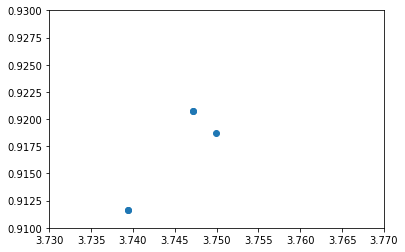

In [274]:
xs = []
ys = []
for id, obj in ans:
    xs.append(obj[0]["coord_ra"])
    ys.append(obj[0]["coord_dec"])
    
plt.scatter(xs, ys)
plt.ylim(ymin = 0.91, ymax=0.93)
plt.xlim(xmin = 3.73, xmax=3.77)